In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure
import plotly.graph_objects as go

import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

**Step 1: Dataset Acquisition**

- The dataset typically includes information such as Date, Open, High, Low, Close, Volume, and potentially other columns. For this project, I have primarily taken the 'Close' price, which represents the closing price of AAPL stock for each trading day.

In [2]:
df = pd.read_csv('/kaggle/input/apple-stock-price-data-from-2015-to-2020/AAPL.csv')
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


**Step 2: Data Preprocessing**

- Loaded the acquired dataset into a Pandas DataFrame, a powerful data manipulation tool in Python.

- Converted the 'Date' column to a datetime data type and set it as the DataFrame's index. This was useful while working with time-series data effectively.

- Explored the dataset by printing the first few rows to understand its structure and contents. 

In [3]:
print(df.columns)
print(df.head())


Index(['Unnamed: 0', 'symbol', 'date', 'close', 'high', 'low', 'open',
       'volume', 'adjClose', 'adjHigh', 'adjLow', 'adjOpen', 'adjVolume',
       'divCash', 'splitFactor'],
      dtype='object')
   Unnamed: 0 symbol                       date    close     high     low  \
0           0   AAPL  2015-05-27 00:00:00+00:00  132.045  132.260  130.05   
1           1   AAPL  2015-05-28 00:00:00+00:00  131.780  131.950  131.10   
2           2   AAPL  2015-05-29 00:00:00+00:00  130.280  131.450  129.90   
3           3   AAPL  2015-06-01 00:00:00+00:00  130.535  131.390  130.05   
4           4   AAPL  2015-06-02 00:00:00+00:00  129.960  130.655  129.32   

     open    volume    adjClose     adjHigh      adjLow     adjOpen  \
0  130.34  45833246  121.682558  121.880685  119.844118  120.111360   
1  131.86  30733309  121.438354  121.595013  120.811718  121.512076   
2  131.23  50884452  120.056069  121.134251  119.705890  120.931516   
3  131.20  32112797  120.291057  121.078960  119.844

#Visualizing Apple stock price from 2015 to 2021
**Step 3: Exploratory Data Analysis (EDA)**

- To gain insights into the data, performed exploratory data analysis.

- Visualized the AAPL stock price data over time using a line plot. 

- Calculated and visualized daily returns, which show how much the stock price changes from one day to the next. This helps identify periods of growth and decline.

In [4]:
#figure(figsize=(8, 6), dpi=80)
fig1 = go.Figure(data=[go.Candlestick(x=df["date"],
                                        open=df["open"],
                                        high=df["high"],
                                        low=df["low"],
                                        close=df["close"])])
fig1.update_layout(title = "Apple Stock Price Analysis", xaxis_rangeslider_visible=True)
fig1.show()

#Visualizing daily returns of Apple stock

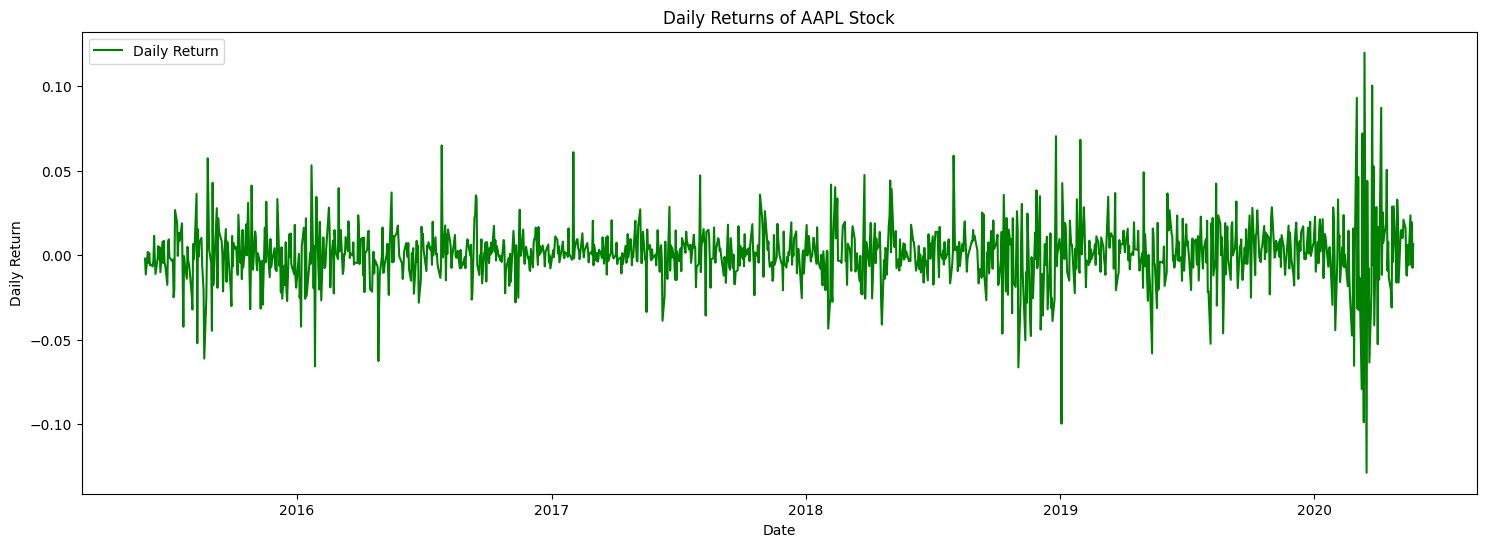

In [5]:
df2 = pd.read_csv('/kaggle/input/apple-stock-price-data-from-2015-to-2020/AAPL.csv')
df2['Date'] = pd.to_datetime(df2['date'])
df2.set_index('Date', inplace=True)

# Calculate and visualize daily returns
df2['Daily_Return'] = df2['close'].pct_change()
plt.figure(figsize=(18, 6))
plt.title('Daily Returns of AAPL Stock')
plt.plot(df2.index, df2['Daily_Return'], label='Daily Return', color='green')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

#Data scaling
**Step 4: Data Normalization**

Normalized the 'Close' price data using Min-Max scaling. This scaling technique transforms the values to a consistent range between 0 and 1, making it easier for the neural network to learn.

In [6]:
#Scale the data
df1=df.reset_index()['close']
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))
print(df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


#Splitting dataset into train and test sets
**Step 5: Data Splitting**

- Splited the normalized data into training and testing sets. In this project, we use 80% of the data for training and the remaining 20% for testing. This separation leads to evaluate the model's performance on unseen data.

In [7]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

print(training_size)
print(test_size)

817
441


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape)
print(y_train.shape)

(716, 100)
(716,)


In [11]:
print(X_test.shape)
print(y_test.shape)

(340, 100)
(340,)


In [12]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

#Building the Stacked LSTM model
**Step 6: Model Building**

- Defined the architecture of the LSTM (Long Short-Term Memory) model. LSTMs are well-suited for time series prediction tasks because they can capture long-term dependencies.

- Created a stacked LSTM model with multiple LSTM layers. Stacked LSTMs can capture complex temporal patterns in the data.

**Step 7: Model Compilation**

- Compiled the LSTM model by specifying the optimizer and loss function. In this case, I have used the 'adam' optimizer and mean squared error (MSE) as the loss function. MSE is commonly used for regression tasks like stock price prediction.

In [13]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


#Stacked LSTM model training for 200 epochs
**Step 8: Model Training**

- Trained the LSTM model using the training dataset. During training, the model learns to make predictions based on the historical stock price data.
Monitor the training process, including changes in training and validation loss, over multiple training epochs.

- I am training the model for 200 epochs

In [15]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
12/12 [==============================] - 9s 291ms/step - loss: 0.0205 - val_loss: 0.0427
Epoch 2/200
12/12 [==============================] - 2s 183ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 3/200
12/12 [==============================] - 2s 188ms/step - loss: 0.0014 - val_loss: 0.0039
Epoch 4/200
12/12 [==============================] - 3s 220ms/step - loss: 8.5049e-04 - val_loss: 0.0042
Epoch 5/200
12/12 [==============================] - 2s 196ms/step - loss: 7.0025e-04 - val_loss: 0.0055
Epoch 6/200
12/12 [==============================] - 2s 190ms/step - loss: 6.5678e-04 - val_loss: 0.0041
Epoch 7/200
12/12 [==============================] - 2s 190ms/step - loss: 6.1360e-04 - val_loss: 0.0044
Epoch 8/200
12/12 [==============================] - 2s 188ms/step - loss: 6.0169e-04 - val_loss: 0.0035
Epoch 9/200
12/12 [==============================] - 2s 189ms/step - loss: 5.8975e-04 - val_loss: 0.0038
Epoch 10/200
12/12 [==============================] - 2s 187ms/step

**Step 9: Model Evaluation** (Not performed)

- After training, evaluated the model's performance on the testing dataset to assess how well it generalizes to unseen data. However, this project focuses on prediction and visualization.

#Predicting future stock price of Apple
**Step 10: Prediction**

- Utilized the trained LSTM model to make predictions on the testing dataset. Predictions are generated in sequences of data points.

In [16]:
#Predict and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 1s 50ms/step


**Step 11: Inverse Scaling**

- Inverse transform the predicted and actual values to bring them back to their original scale (USD) from the normalized scale. This step is crucial for comparing predictions with actual stock prices.

In [18]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [19]:
#Calculate RMSE performance metrics
print(math.sqrt(mean_squared_error(y_train,train_predict)))
print(math.sqrt(mean_squared_error(y_test,test_predict)))

33925.074917162405
56907.71258794304


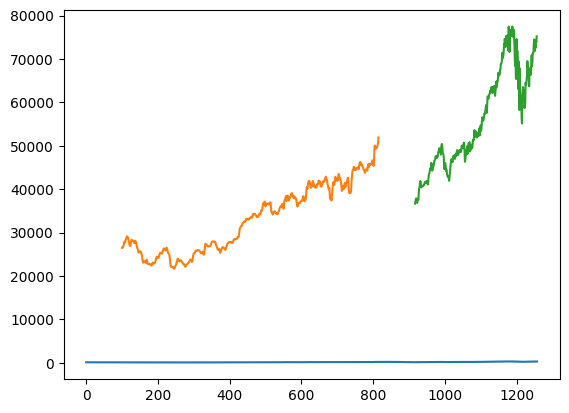

In [20]:
#Plotting the results
#figure(figsize=(8, 6), dpi=80)
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [21]:
# demonstrate prediction for the next 30 days
x_input=test_data[341:].reshape(1,-1)
print(x_input.shape)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

(1, 100)


In [22]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
print(len(df1))

1258


#Visualizing the price predictions for the next 30 days
**Step 12: Result Visualization**

- Visualized the actual and predicted stock prices over time. Plotting these values on a graph gives assess to how effectively the LSTM model predicts future stock prices based on historical data.

Text(0.5, 1.0, 'Stock price prediction for the next 30 days')

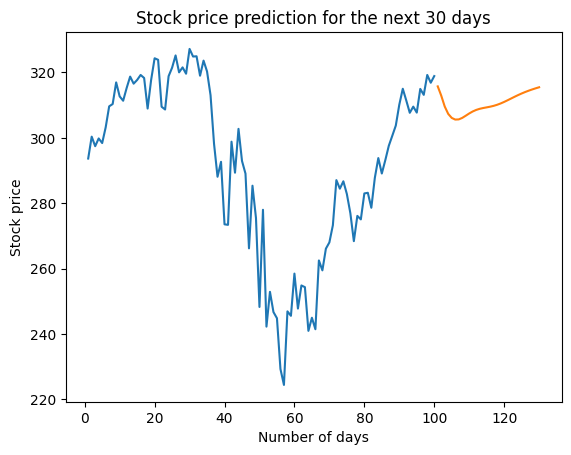

In [23]:
#Prediction plot for the next 30 days
#figure(figsize=(8, 6), dpi=80)
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))
plt.xlabel("Number of days")
plt.ylabel("Stock price")
plt.title("Stock price prediction for the next 30 days")

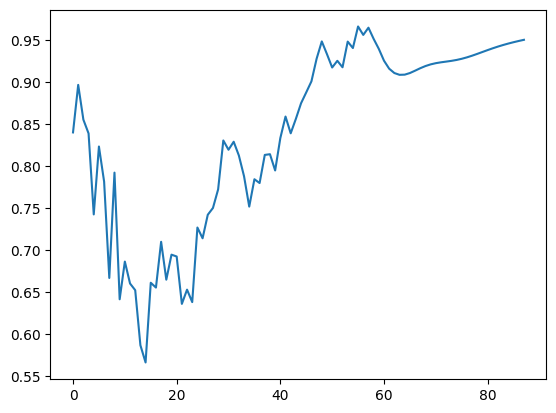

In [24]:
#Prediction plot for the next 30 days
#figure(figsize=(8, 6), dpi=80)
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

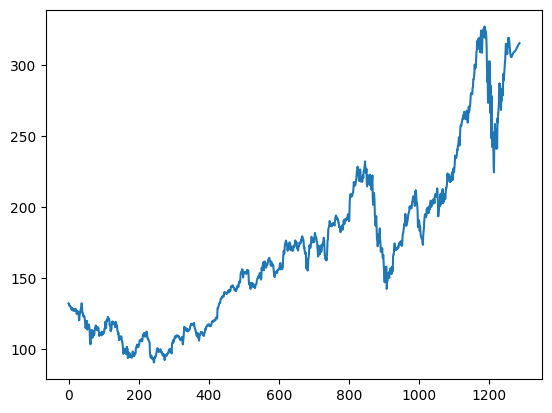

In [25]:
#Final plot with the prediction for next 30 days
#figure(figsize=(8, 6), dpi=80)
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)